<a href="https://colab.research.google.com/github/harisgulzar1/RoadDistressAnalysis/blob/main/Lecture3_1_RoadDistressAnalysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Yolov6 Implementation

In [3]:
# Clone and install MT-YOLOv6
!git clone https://github.com/meituan/YOLOv6.git
!cd YOLOv6
!pip install -r /content/YOLOv6/requirements.txt

Cloning into 'YOLOv6'...
remote: Enumerating objects: 3838, done.
remote: Counting objects: 100% (1711/1711), done.
remote: Compressing objects: 100% (329/329), done.
remote: Total 3838 (delta 1502), reused 1394 (delta 1382), pack-reused 2127
Receiving objects: 100% (3838/3838), 47.12 MiB | 13.92 MiB/s, done.
Resolving deltas: 100% (2340/2340), done.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.9/15.9 MB 89.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 89.5 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-m

In [7]:
#@title Set-up model. { run: "auto" }
checkpoint:str ="yolov6s" #@param ["yolov6s", "yolov6n", "yolov6t"]
device:str = "gpu"#@param ["gpu", "cpu"]
half:bool = False #@param {type:"boolean"}
img_size:int = 640#@param {type:"integer"}



import os, requests, torch, math, cv2
import numpy as np
import PIL
#Change directory so that imports wortk correctly
if os.getcwd()=="/content":
  os.chdir("YOLOv6")
from yolov6.utils.events import LOGGER, load_yaml
from yolov6.layers.common import DetectBackend
from yolov6.data.data_augment import letterbox
from yolov6.utils.nms import non_max_suppression
from yolov6.core.inferer import Inferer

from typing import List, Optional
#Download weights


if not os.path.exists(f"{checkpoint}.pt"):
  print("Downloading checkpoint...")
  os.system(f"""wget -c https://github.com/meituan/YOLOv6/releases/download/0.4.0/{checkpoint}.pt""")

#Set-up hardware options
cuda = device != 'cpu' and torch.cuda.is_available()
device = torch.device('cuda:0' if cuda else 'cpu')

def check_img_size(img_size, s=32, floor=0):
  def make_divisible( x, divisor):
    # Upward revision the value x to make it evenly divisible by the divisor.
    return math.ceil(x / divisor) * divisor
  """Make sure image size is a multiple of stride s in each dimension, and return a new shape list of image."""
  if isinstance(img_size, int):  # integer i.e. img_size=640
      new_size = max(make_divisible(img_size, int(s)), floor)
  elif isinstance(img_size, list):  # list i.e. img_size=[640, 480]
      new_size = [max(make_divisible(x, int(s)), floor) for x in img_size]
  else:
      raise Exception(f"Unsupported type of img_size: {type(img_size)}")

  if new_size != img_size:
      print(f'WARNING: --img-size {img_size} must be multiple of max stride {s}, updating to {new_size}')
  return new_size if isinstance(img_size,list) else [new_size]*2

def process_image(path, img_size, stride, half):
  '''Process image before image inference.'''
  try:
    from PIL import Image
    img_src = np.asarray(Image.open(requests.get(url, stream=True).raw))
    assert img_src is not None, f'Invalid image: {path}'
  except Exception as e:
    LOGGER.Warning(e)
  image = letterbox(img_src, img_size, stride=stride)[0]

  # Convert
  image = image.transpose((2, 0, 1))  # HWC to CHW
  image = torch.from_numpy(np.ascontiguousarray(image))
  image = image.half() if half else image.float()  # uint8 to fp16/32
  image /= 255  # 0 - 255 to 0.0 - 1.0

  return image, img_src


model = DetectBackend(f"./content/YOLOv6/{checkpoint}.pt", device=device)
# checkpoint = torch.load('/content/YOLOv6/runs/train/exp3/weights/last_ckpt.pt')
# model.load_state_dict(checkpoint['model_state_dict'])
stride = model.stride
class_names = load_yaml("./data/coco.yaml")['names']

if half & (device.type != 'cpu'):
  model.model.half()
else:
  model.model.float()
  half = False

# if device.type != 'cpu':
#   model(torch.zeros(1, 3, *img_size).to(device).type_as(next(model.model.parameters())))  # warmup


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,


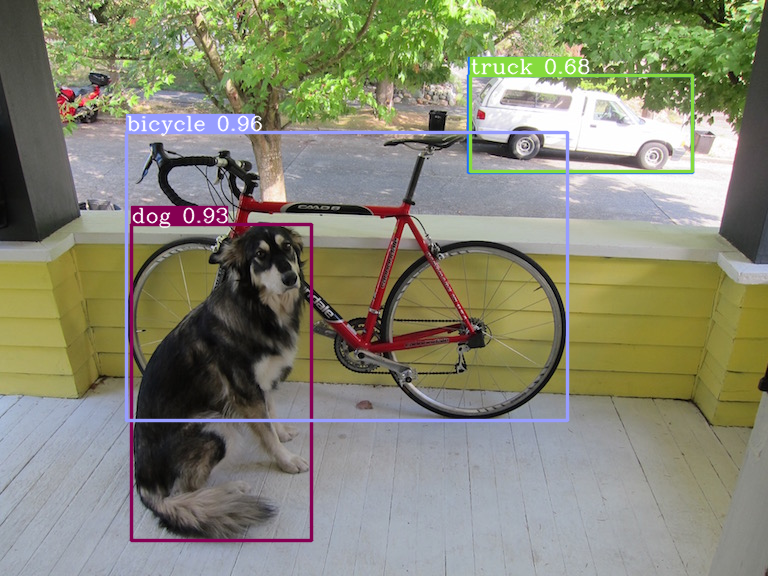

In [8]:
#@title Run YOLOv6 on an image from a URL. { run: "auto" }
url:str = "https://djl.ai/examples/src/test/resources/dog_bike_car.jpg" #@param {type:"string"}
hide_labels: bool = False #@param {type:"boolean"}
hide_conf: bool = False #@param {type:"boolean"}



img_size:int = 640#@param {type:"integer"}

conf_thres: float =.25 #@param {type:"number"}
iou_thres: float =.45 #@param {type:"number"}
max_det:int =  1000#@param {type:"integer"}
agnostic_nms: bool = False #@param {type:"boolean"}


img_size = check_img_size(img_size, s=stride)

img, img_src = process_image(url, img_size, stride, half)
img = img.to(device)
if len(img.shape) == 3:
    img = img[None]
    # expand for batch dim
pred_results = model(img)
classes:Optional[List[int]] = None # the classes to keep
det = non_max_suppression(pred_results, conf_thres, iou_thres, classes, agnostic_nms, max_det=max_det)[0]

gn = torch.tensor(img_src.shape)[[1, 0, 1, 0]]  # normalization gain whwh
img_ori = img_src.copy()
if len(det):
  det[:, :4] = Inferer.rescale(img.shape[2:], det[:, :4], img_src.shape).round()
  for *xyxy, conf, cls in reversed(det):
      class_num = int(cls)
      label = None if hide_labels else (class_names[class_num] if hide_conf else f'{class_names[class_num]} {conf:.2f}')
      Inferer.plot_box_and_label(img_ori, max(round(sum(img_ori.shape) / 2 * 0.003), 2), xyxy, label, color=Inferer.generate_colors(class_num, True))
PIL.Image.fromarray(img_ori)